In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import random
from torch.utils.data import Dataset, DataLoader


## transformer model

In [2]:
# -----------------------------
# 1. Positional Encoding Module
# -----------------------------
class PositionalEncoding(nn.Module):
    """Implements the sinusoidal positional encoding as in 'Attention Is All You Need'."""
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # odd indices
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, seq_length, d_model)
        Returns:
            Tensor: (batch_size, seq_length, d_model) with positional encodings added.
        """
        return x + self.pe[:, :x.size(1)]

# -----------------------------
# 2. Transformer-based Parity Classifier
# -----------------------------
class TransformerParityClassifier(nn.Module):
    def __init__(self,
                 d_model=32,
                 nhead=4,
                 num_layers=2,
                 dim_feedforward=64,
                 dropout=0.1,
                 max_seq_length=16):
        """
        Args:
            d_model: Embedding dimension.
            nhead: Number of attention heads.
            num_layers: Number of transformer encoder layers.
            dim_feedforward: Hidden dimension in the feedforward network.
            dropout: Dropout probability.
            max_seq_length: Maximum length of binary sequence (i.e. number of bits).
        """
        super().__init__()
        # Only two tokens: 0 and 1.
        self.embedding = nn.Embedding(num_embeddings=2, embedding_dim=d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_seq_length)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model,
                                                   nhead=nhead,
                                                   dim_feedforward=dim_feedforward,
                                                   dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Final classification head: output two logits (even/odd)
        self.fc = nn.Linear(d_model, 2)

    def forward(self, x):
        """
        Args:
            x: LongTensor of shape (batch_size, seq_length) containing 0/1 tokens.
        Returns:
            Tensor of shape (batch_size, 2): logits for each class.
        """
        # Embed the tokens: (batch_size, seq_length, d_model)
        x = self.embedding(x)
        # Add positional encoding
        x = self.pos_encoder(x)
        # Transformer expects shape (seq_length, batch_size, d_model)
        x = x.transpose(0, 1)
        x = self.transformer_encoder(x)
        # Pool over the sequence. Here, we simply average the token representations.
        x = x.mean(dim=0)  # (batch_size, d_model)
        logits = self.fc(x)  # (batch_size, 2)
        return logits


## data preparation

In [3]:
# -----------------------------
# 3. Dataset Creation: Generating Binary Numbers and Labels
# -----------------------------
def generate_binary_integer(max_value=2**16 - 1, seq_length=16):
    """
    Randomly generate a positive integer, convert it to binary (padded to seq_length bits),
    and compute its parity (x mod 2).
    Returns:
        bits: List of integers (0 or 1) of length seq_length.
        label: 0 if even, 1 if odd.
    """
    x = random.randint(1, max_value)
    binary_str = bin(x)[2:]  # Remove the '0b' prefix.
    # Pad with zeros to get a fixed-length representation.
    binary_str = binary_str.zfill(seq_length)
    bits = [int(ch) for ch in binary_str]
    label = x % 2  # Parity: 0 (even) or 1 (odd)
    return bits, label

class ParityDataset(Dataset):
    def __init__(self, num_samples=10000, seq_length=16, max_value=2**16 - 1):
        self.samples = []
        for _ in range(num_samples):
            bits, label = generate_binary_integer(max_value=max_value, seq_length=seq_length)
            # Convert to torch tensors.
            bits_tensor = torch.tensor(bits, dtype=torch.long)
            label_tensor = torch.tensor(label, dtype=torch.long)
            self.samples.append((bits_tensor, label_tensor))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


## training and evaluation functions

In [4]:
# -----------------------------
# 4. Training and Evaluation Functions
# -----------------------------
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)  # (batch_size, 2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


## training

In [5]:
# -----------------------------
# 5. Setup and Training Loop
# -----------------------------
# Hyperparameters
seq_length = 16         # Number of bits in our binary representation.
num_samples = 10000     # Total number of examples in our dataset.
batch_size = 64
num_epochs = 5
learning_rate = 0.001

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create dataset and dataloader.
dataset = ParityDataset(num_samples=num_samples, seq_length=seq_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate the model.
model = TransformerParityClassifier(max_seq_length=seq_length)
model.to(device)

# Define loss function and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop (runs immediately when you execute the script)
for epoch in range(num_epochs):
    train_loss = train_model(model, dataloader, optimizer, criterion, device)
    accuracy = evaluate_model(model, dataloader, device)
    print(f"Epoch {epoch + 1}/{num_epochs} -- Loss: {train_loss:.4f} -- Accuracy: {accuracy * 100:.2f}%")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/5 -- Loss: 0.2474 -- Accuracy: 100.00%
Epoch 2/5 -- Loss: 0.0014 -- Accuracy: 100.00%
Epoch 3/5 -- Loss: 0.0006 -- Accuracy: 100.00%
Epoch 4/5 -- Loss: 0.0004 -- Accuracy: 100.00%
Epoch 5/5 -- Loss: 0.0002 -- Accuracy: 100.00%


## visualization

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# --- Visualization Functions ---

def visualize_embeddings(model):
    """
    Visualize the learned embedding weights for the two tokens (0 and 1).
    Projects high-dimensional embeddings down to 2D using a simple PCA.
    """
    # Extract embeddings: shape (2, d_model)
    embeddings = model.embedding.weight.detach().cpu().numpy()
    d_model = embeddings.shape[1]
    
    # Reduce to 2D if necessary.
    if d_model > 2:
        embeddings_centered = embeddings - embeddings.mean(axis=0)
        # Compute SVD for PCA.
        U, S, Vt = np.linalg.svd(embeddings_centered, full_matrices=False)
        embeddings_2d = embeddings_centered.dot(Vt.T[:, :2])
    else:
        embeddings_2d = embeddings

    plt.figure(figsize=(6, 5))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=['red', 'blue'], s=100)
    for i, label in enumerate(["0", "1"]):
        plt.annotate(label, (embeddings_2d[i, 0] + 0.01, embeddings_2d[i, 1] + 0.01), fontsize=12)
    plt.title("2D Projection of Token Embeddings")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()


def visualize_fc_weights(model):
    """
    Visualize the weights of the final classification layer as a heatmap.
    """
    fc_weights = model.fc.weight.detach().cpu().numpy()  # Shape: (2, d_model)
    plt.figure(figsize=(8, 3))
    plt.imshow(fc_weights, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.yticks([0, 1], ["Even", "Odd"])
    plt.xlabel("Hidden Units")
    plt.title("Final Classification Layer Weights")
    plt.show()


# --- Output (Inference) Function ---

def predict_parity(x, model, seq_length=16, device=torch.device("cpu")):
    """
    Given an integer x, converts it to a binary representation (zero-padded to seq_length),
    passes it through the model, and returns the predicted parity ("Even" or "Odd").

    Args:
        x (int): The input integer.
        model: The trained TransformerParityClassifier.
        seq_length (int): Number of bits for the binary representation.
        device: Torch device.

    Returns:
        str: "Even" if the prediction is even, "Odd" otherwise.
    """
    # Convert integer to binary string and pad with zeros.
    binary_str = bin(x)[2:].zfill(seq_length)
    bits = [int(b) for b in binary_str]
    bits_tensor = torch.tensor(bits, dtype=torch.long).unsqueeze(0).to(device)  # Shape: (1, seq_length)
    
    model.eval()
    with torch.no_grad():
        output = model(bits_tensor)
        pred = output.argmax(dim=1).item()
    return "Even" if pred == 0 else "Odd"


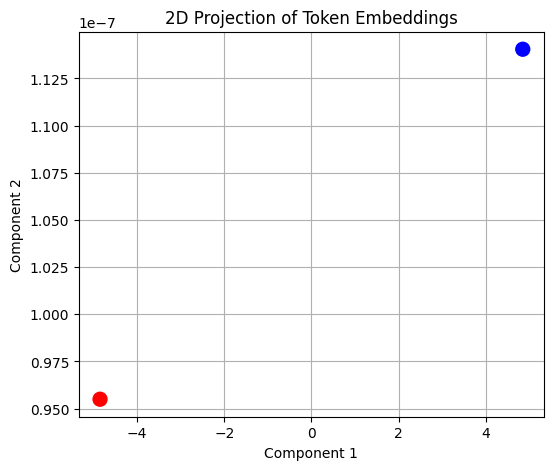

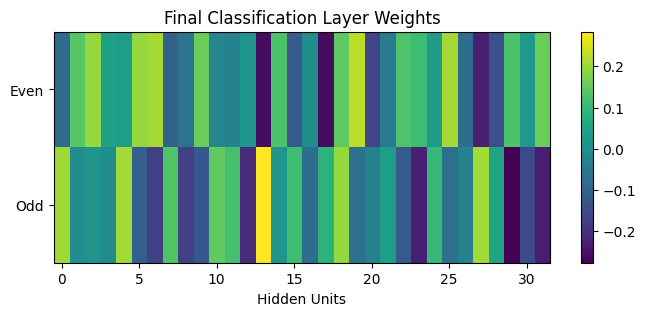

Predicted parity for 42: Even


In [7]:
# Visualize the learned token embeddings.
visualize_embeddings(model)

# Visualize the final classification layer's weights.
visualize_fc_weights(model)

# Predict the parity for a specific integer.
input_number = 42  # Replace with any integer.
result = predict_parity(input_number, model, seq_length=16, device=device)
print(f"Predicted parity for {input_number}: {result}")
